In [ ]:
# Import TensorFlow library for deep learning tasks
import tensorflow as tf

# Import the Sequential model to create a linear stack of layers
from tensorflow.keras.models import Sequential

# Import layers for building the neural network
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Import the Adam optimizer for training the model
from tensorflow.keras.optimizers import Adam

# Import learning rate scheduling for the optimizer
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Import EarlyStopping callback to stop training if the model stops improving
from tensorflow.keras.callbacks import EarlyStopping

# Import the VGG16 pre-trained model for transfer learning
from tensorflow.keras.applications import VGG16

# Import ImageDataGenerator for data augmentation during training
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Import train_test_split to split the dataset into training and testing sets
from sklearn.model_selection import train_test_split

# Import shuffle to randomize the order of elements in a list
from sklearn.utils import shuffle

# Import classification metrics for model evaluation
from sklearn.metrics import classification_report, confusion_matrix

# Import NumPy for numerical operations
import numpy as np

# Import the os module for interacting with the operating system
import os

# Import the Python Imaging Library (PIL) for image processing
from PIL import Image, ImageChops, ImageEnhance

# Import Matplotlib for data visualization
import matplotlib.pyplot as plt

# Import JSON for handling JSON data
import json

# Import tqdm for displaying progress bars
from tqdm import tqdm

# Import Seaborn for statistical data visualization
import seaborn as sns

# Import Google Colab's drive module to mount Google Drive
from google.colab import drive

# Mount Google Drive to access files
drive.mount("/content/drive")


Mounted at /content/drive


In [ ]:
# Function to convert an image to its Error Level Analysis (ELA) representation
def convert_to_ela_image(path, quality):
    # Open the original image and convert it to the RGB color mode
    original_image = Image.open(path).convert('RGB')

    # Save a resaved version of the image with specified JPEG quality
    resaved_file_name = 'resaved_image.jpg'
    original_image.save(resaved_file_name, 'JPEG', quality=quality)

    # Open the resaved image
    resaved_image = Image.open(resaved_file_name)

    # Compute the difference between the original and resaved images using ImageChops
    ela_image = ImageChops.difference(original_image, resaved_image)

    # Calculate the extrema (minimum and maximum pixel values) of the ela_image
    extrema = ela_image.getextrema()

    # Find the maximum difference in pixel values
    max_difference = max([pix[1] for pix in extrema])

    # If the maximum difference is zero, set it to 1 to avoid division by zero
    if max_difference == 0:
        max_difference = 1

    # Scale the ela_image based on the maximum difference
    scale = 255 / max_difference
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image

# Function to prepare an image for model input
def prepare_image(image_path):
    # Define the target image size
    image_size = (128, 128)

    # Convert the image to its ELA representation with a specified quality
    ela_image = convert_to_ela_image(image_path, 90)

    # Resize the ELA image to the target size and convert it to a NumPy array
    reshaped_image = np.array(ela_image.resize(image_size))

    # Normalize pixel values to the range [0, 1]
    return reshaped_image / 255.0


In [ ]:
# Function to build a Convolutional Neural Network (CNN) model
def build_model(input_shape):
    model = Sequential()

    # Convolutional layer with 32 filters, a 5x5 kernel, and ReLU activation
    model.add(Conv2D(32, (5, 5), activation='relu', input_shape=input_shape))

    # MaxPooling layer to down-sample spatial dimensions by a factor of 2x2
    model.add(MaxPooling2D(2, 2))

    # Convolutional layer with 64 filters, a 3x3 kernel, and ReLU activation
    model.add(Conv2D(64, (3, 3), activation='relu'))

    # MaxPooling layer
    model.add(MaxPooling2D(2, 2))

    # Convolutional layer with 128 filters, a 3x3 kernel, and ReLU activation
    model.add(Conv2D(128, (3, 3), activation='relu'))

    # Additional Convolutional layer with 128 filters and 3x3 kernel, and ReLU activation
    model.add(Conv2D(128, (3, 3), activation='relu'))

    # MaxPooling layer
    model.add(MaxPooling2D(2, 2))

    # Convolutional layer with 256 filters, a 3x3 kernel, and ReLU activation
    model.add(Conv2D(256, (3, 3), activation='relu'))

    # Convolutional layer with 256 filters, a 3x3 kernel, ReLU activation, and 'SAME' padding
    model.add(Conv2D(256, (3, 3), activation='relu', padding="SAME"))

    # Flatten layer to convert 2D feature maps to a 1D vector
    model.add(Flatten())

    # Fully connected layer with 128 neurons and ReLU activation
    model.add(Dense(128, activation='relu'))

    # Dropout layer to reduce overfitting by randomly setting a fraction of input units to 0
    model.add(Dropout(0.5))

    # Fully connected layer with 64 neurons and ReLU activation
    model.add(Dense(64, activation='relu'))

    # Another Dropout layer
    model.add(Dropout(0.5))

    # Output layer with 1 neuron and sigmoid activation for binary classification
    model.add(Dense(1, activation='sigmoid'))

    return model


In [ ]:
# Function to create a modified VGG16 model for binary classification
def create_vgg16_model(input_shape):
    # Load the VGG16 base model pre-trained on ImageNet data
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Set the base model to non-trainable (freeze its weights)
    base_model.trainable = False

    # Build a Sequential model consisting of the VGG16 base model, additional layers, and output layer
    model = Sequential([
        base_model,            # Include the VGG16 base model
        Flatten(),             # Flatten layer to convert 2D feature maps to a 1D vector
        Dense(128, activation='relu'),  # Fully connected layer with 128 neurons and ReLU activation
        Dropout(0.5),          # Dropout layer to reduce overfitting by randomly setting a fraction of input units to 0
        Dense(64, activation='relu'),   # Fully connected layer with 64 neurons and ReLU activation
        Dropout(0.5),          # Another Dropout layer
        Dense(1, activation='sigmoid')   # Output layer with 1 neuron and sigmoid activation for binary classification
    ])

    return model


In [ ]:
# Function to train a model with optional VGG16 base using provided data
def train_model(X_train, Y_train, X_val, Y_val, epochs=10, batch_size=32, use_vgg16=False):
    # Get the shape of the input data
    input_shape = X_train[0].shape

    # Create the model using either a custom build or a modified VGG16 base
    if use_vgg16:
        model = create_vgg16_model(input_shape)
    else:
        model = build_model(input_shape)

    # Define a learning rate(for optimizing) scheduler using Exponential Decay
    learning_rate = ExponentialDecay(initial_learning_rate=1e-4, decay_steps=10000, decay_rate=0.9, staircase=True)

    # Define data augmentation for training data using ImageDataGenerator
    train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
    )

    # Create a generator for training data with the specified data augmentation
    train_generator = train_datagen.flow(X_train, Y_train, batch_size=batch_size)

    # Initialize the Adam optimizer with the defined learning rate scheduler
    optimizer = Adam(learning_rate=learning_rate)

    # Compile the model with binary crossentropy loss and accuracy as a metric
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Define EarlyStopping to stop training if validation accuracy stops improving
    early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=0, mode='auto')

    # Compute class weights to handle class imbalance
    class_weights = compute_class_weight('balanced', classes=np.unique(Y_train), y=Y_train)
    class_weight_dict = dict(enumerate(class_weights))

    # Train the model using the training generator and validate on the validation data
    history = model.fit(train_generator, epochs=epochs, validation_data=(X_val, Y_val), callbacks=[early_stopping], class_weight=class_weight_dict)

    # Return the trained model and training history
    return model, history


In [ ]:
# Function to evaluate a model's performance on test data
def evaluate_model(model, X_test, Y_test):
    # Predict probabilities for test data
    Y_pred = model.predict(X_test)

    # Convert predicted probabilities to binary classes using rounding
    Y_pred_classes = np.round(Y_pred)

    # True labels from the test set
    Y_true = Y_test

    # Compute confusion matrix and plot it
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
    plot_confusion_matrix(confusion_mtx)  # Assuming there's a function for plotting confusion matrix

    # Display classification report
    print(classification_report(Y_true, Y_pred_classes))

    # Calculate and display accuracy
    correct_test = np.sum(Y_pred_classes.flatten() == Y_true)
    total_test = len(Y_true)
    accuracy = correct_test / total_test
    print(f'Total test images: {total_test}\nCorrectly predicted images: {correct_test}\nAccuracy: {accuracy:.2%}')


In [ ]:
# Function to plot training and validation history metrics (loss and accuracy)
def plot_training_history(history):
    # Create subplots with 1 row and 2 columns
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    # Plot training and validation loss
    ax[0].plot(history.history['loss'], label='Training loss')
    ax[0].plot(history.history['val_loss'], label='Validation loss')
    ax[0].set_xlabel('Epochs', fontsize=16)
    ax[0].set_ylabel('Loss', fontsize=16)
    ax[0].legend(loc='best', shadow=True)

    # Plot training and validation accuracy
    ax[1].plot(history.history['accuracy'], label='Training accuracy')
    ax[1].plot(history.history['val_accuracy'], label='Validation accuracy')
    ax[1].set_xlabel('Epochs', fontsize=16)
    ax[1].set_ylabel('Accuracy', fontsize=16)
    ax[1].legend(loc='best', shadow=True)

    # Set the title for the entire plot
    fig.suptitle('Metrics', fontsize=20)

    # Display the plot
    plt.show()


In [ ]:
# Function to plot a confusion matrix using Seaborn's heatmap
def plot_confusion_matrix(cf_matrix):
    # Format values for group counts and percentages in the confusion matrix
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

    # Define axis labels for the confusion matrix
    axes_labels = ['Forged', 'Authentic']

    # Combine group counts and percentages for display in the heatmap
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    # Use Seaborn's heatmap to visualize the confusion matrix
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap="flare", xticklabels=axes_labels, yticklabels=axes_labels)


In [ ]:
# Main block to execute when the script is run
if __name__ == "__main__":
    # Specify paths to the dataset
    paths = ['/content/drive/My Drive/CASIA/CASIA2/Au/', '/content/drive/My Drive/CASIA/CASIA2/Tp/']

    # Load and preprocess a subset of data
    subset_size = 500  # Adjust the subset size as needed

    # Initialize empty lists to store preprocessed images and labels
    X, Y = [], []

    # Iterate over labels and their corresponding paths
    for label, path in enumerate(paths):
        # Iterate over filenames in the specified path, limited by the subset size
        for filename in tqdm(os.listdir(path)[:subset_size], desc=f"Processing Images for label {label}"):
            # Check if the filename has a valid image file extension
            if filename.lower().endswith(('jpg', 'png', 'jpeg')):
                try:
                    # Create the full path to the image
                    full_path = os.path.join(path, filename)

                    # Prepare the image using the previously defined 'prepare_image' function
                    X.append(prepare_image(full_path))

                    # Append the label to the Y list
                    Y.append(label)
                except Exception as e:
                    print(f"Error processing {filename}: {e}")

    # Shuffle the X and Y lists for randomness
    X, Y = shuffle(X, Y, random_state=42)

    # Save the processed data as NumPy arrays
    np.save('/content/drive/My Drive/CASIA/proposed_fidac_500_x.npy', X, allow_pickle=True)
    np.save('/content/drive/My Drive/CASIA/proposed_fidac_500_y.npy', Y, allow_pickle=True)


Processing Images for label 1: 100%|██████████| 500/500 [03:08<00:00,  2.65it/s]


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Load processed data
X = np.load('/content/drive/My Drive/CASIA/proposed_fidac_500_x.npy', allow_pickle=True)
Y = np.load('/content/drive/My Drive/CASIA/proposed_fidac_500_y.npy', allow_pickle=True)

# Train/test split--- splitting dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.05, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

# Train the model
trained_model, training_history = train_model(X_train, Y_train, X_val, Y_val, epochs=5)
# Save the trained model
trained_model.save('/content/drive/My Drive/CASIA/ela_casia.h5')

# Save the training history
with open('/content/drive/My Drive/CASIA/model_history.json', 'w') as f:
    json.dump(training_history.history, f)

Epoch 1/5
15/15 [==============================] - 44s 3s/step - loss: 0.6888 - accuracy: 0.8000 - val_loss: 0.6217 - val_accuracy: 0.8000
Epoch 2/5
15/15 [==============================] - 41s 3s/step - loss: 0.6816 - accuracy: 0.8174 - val_loss: 0.5728 - val_accuracy: 0.8000
Epoch 3/5
15/15 [==============================] - 44s 3s/step - loss: 0.6373 - accuracy: 0.8261 - val_loss: 0.4712 - val_accuracy: 0.8000
Epoch 4/5
15/15 [==============================] - 43s 3s/step - loss: 0.5527 - accuracy: 0.8413 - val_loss: 0.3538 - val_accuracy: 0.8174
Epoch 5/5
15/15 [==============================] - 44s 3s/step - loss: 0.4949 - accuracy: 0.8826 - val_loss: 0.2864 - val_accuracy: 0.8261


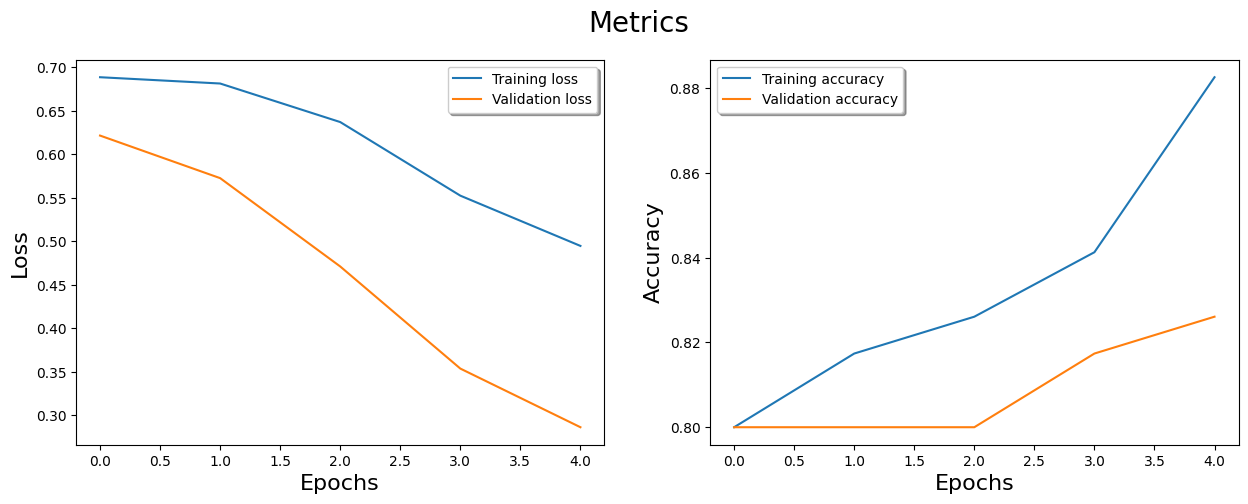

In [ ]:
# Plot training history
plot_training_history(training_history)

1/1 [==============================] - 1s 559ms/step
              precision    recall  f1-score   support

           0       0.86      0.96      0.91        25
           1       0.67      0.33      0.44         6

    accuracy                           0.84        31
   macro avg       0.76      0.65      0.68        31
weighted avg       0.82      0.84      0.82        31

Total test images: 31
Correctly predicted images: 26
Accuracy: 83.87%


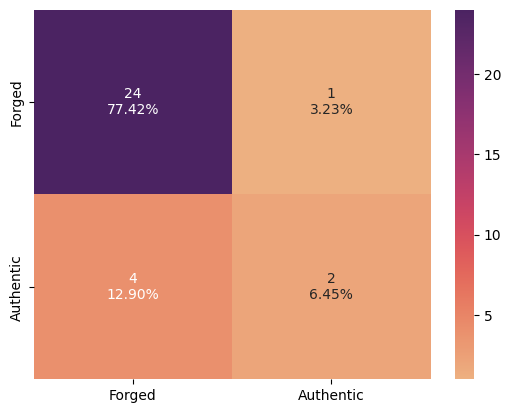

In [ ]:
# Evaluate the model on the test set
evaluate_model(trained_model, X_test, Y_test)


In [ ]:
# Import necessary libraries
from tensorflow.keras.models import load_model
from PIL import Image
import numpy as np

# Load the trained model
model_path = '/content/drive/My Drive/CASIA/ela_casia.h5'
loaded_model = load_model(model_path)

# Function to prepare an image for prediction
def prepare_image_for_prediction(image_path):
    # Define the target image size
    image_size = (128, 128)

    # Convert the image to its ELA representation with a specified quality
    ela_image = convert_to_ela_image(image_path, 90)

    # Resize the ELA image to the target size and convert it to a NumPy array
    reshaped_image = np.array(ela_image.resize(image_size))

    # Expand dimensions to match the expected input shape for prediction
    return np.expand_dims(reshaped_image / 255.0, axis=0)

# Example usage
new_image_path = '/content/drive/My Drive/CASIA/fdemo.jpg'
new_image = prepare_image_for_prediction(new_image_path)

# Make a prediction using the loaded model
prediction = loaded_model.predict(new_image)

# Interpret the prediction and print the result
if prediction[0][0] > 0.5:
    print("The image is predicted as AUTHENTIC.")
else:
    print("The image is predicted as FORGED.")


1/1 [==============================] - 0s 149ms/step
The image is predicted as FORGED.


In [ ]:
# Load necessary libraries
from tensorflow.keras.models import load_model
from PIL import Image
import numpy as np

# Load the trained model
model_path = '/content/drive/My Drive/CASIA/ela_casia.h5'
loaded_model = load_model(model_path)

# Function to prepare an image for prediction
def prepare_image_for_prediction(image_path):
    # Define the target image size
    image_size = (128, 128)

    # Convert the image to its ELA representation with a specified quality
    ela_image = convert_to_ela_image(image_path, 90)

    # Resize the ELA image to the target size and convert it to a NumPy array
    reshaped_image = np.array(ela_image.resize(image_size))

    # Expand dimensions to match the expected input shape for prediction
    return np.expand_dims(reshaped_image / 255.0, axis=0)

# Example usage
new_image_path = '/content/drive/My Drive/CASIA/demo.jpg'
new_image = prepare_image_for_prediction(new_image_path)

# Make a prediction using the loaded model
prediction = loaded_model.predict(new_image)

# Interpret the prediction and print the result
if prediction[0][0] > 0.5:
    print("The image is predicted as AUTHENTIC.")
else:
    print("The image is predicted as FORGED.")


1/1 [==============================] - 0s 254ms/step
The image is predicted as AUTHENTIC.
